# EEG - ERP Preprocessing Script

This script is a preprocessing script for EEG data. The file you're seeing is called a [Jupyter notebook](https://jupyter.org/), which is a way to write and run Python code in a way that is easy to read and understand.

Even if you've never used Python, you can use this notebook to preprocess EEG data. You can run the code in each cell by clicking on the cell and pressing `Shift + Enter`.

This script is designed to be used with the [MNE-Python](https://mne.tools/stable/index.html) library. MNE-Python is a powerful library for analyzing EEG data, and it has many built-in functions for preprocessing, visualization, and analysis.

The first thing we need to do is install MNE-Python. You can do this by running the cell below. (Remember to press `Shift + Enter` to run the code in the cell.)


In [1]:
# pip install mne

In [2]:
import mne
import mne_bids
import os.path as op
from pathlib import Path
from glob import glob
import json
import matplotlib.pyplot as plt
import numpy as np
mne.set_log_level('ERROR')

In [3]:
subject = 'sub-012'

# Get EEG data

Data are stored on a service called GitHub. The command below will copy the data to your workspace.

In [4]:
# !git clone https://github.com/NESC-PSYO-3137/3137_2024-25_EEG.git

# Load EEG data

Raw EEG data is typically stored in a one or more files containing continuous EEG data. There are many different proprietary file formats for EEG data; most of these are developed by the manufacturer of a particular EEG system, since an integral part of an EEG system is software to save the data for later analysis. Fortunately, MNE provides functions to import data from most common EEG systems. 

In the present case, we are working with data from a system sold by Brain Products, whose software is called *Brain Vision*. So we will use MNE's `read_raw_brainvision()` function. The Brain Vision format actually specifies *three files* for any given data set. The three files are all created at the time that the EEG data is acquired, and it's important to ensure that all three are copied when moving them around. The files are as follows:
- `*.eeg` is the actual EEG data (electrical potential measurements for all electrodes, at all time points). This is stored in a compressed (binary) format
- `*.vmrk` is a text file containing all of the markers (*trigger codes*) that were sent to the EEG system during data collection, by the stimulus computer. These typically encode the onset of various stimuli, and times of any responses by the participant, as well as and what each stimulus/response was. 
- `*.vhdr` is a text file with header information, or **metadata** about the data set, including technical details such as the sampling rate, and the settings of the EEG amplifier during the recording. The `.vhdr` file is particularly important because it specifies the file names of the `.eeg` and `.vmrk` files (although they should always be named consistently with the header file). 

When we run `read_raw_brainvision()` the file we will actually pass as an argument is the `.vhdr` file. Since it specifies the names of the associated `.eeg` and `.vmrk` files, from this file MNE can find the data and markers.


In [5]:
in_file = glob(op.join('..', subject, 'eeg', subject + '*.set'))[0]
in_file

'../sub-012/eeg/sub-012_task-N400_eeg.set'

In [6]:
raw = mne.io.read_raw_eeglab(in_file, 
                             eog='auto', 
                             
                             preload=True)
raw.rename_channels({'FP1':'Fp1', 'FP2':'Fp2'})
raw.set_montage('standard_1020')
raw = mne.set_bipolar_reference(raw, 
                                ['HEOG_left', 'VEOG_lower'], 
                                ['HEOG_right', 'Fp1'],
                                ['HEOG', 'VEOG']
                                )

# View raw file metadata

We can view some of the information about the data that's stored with it in the file: the sampling rate, the number of channels, and the names of the channels. This information is stored in the `info` attribute of the `raw` object. We can access it by typing `raw.info`.

In [7]:
raw

<RawEEGLAB | sub-012_task-N400_eeg.fdt, 31 x 399360 (390.0 s), ~94.5 MB, data loaded>

# Plot channel locations

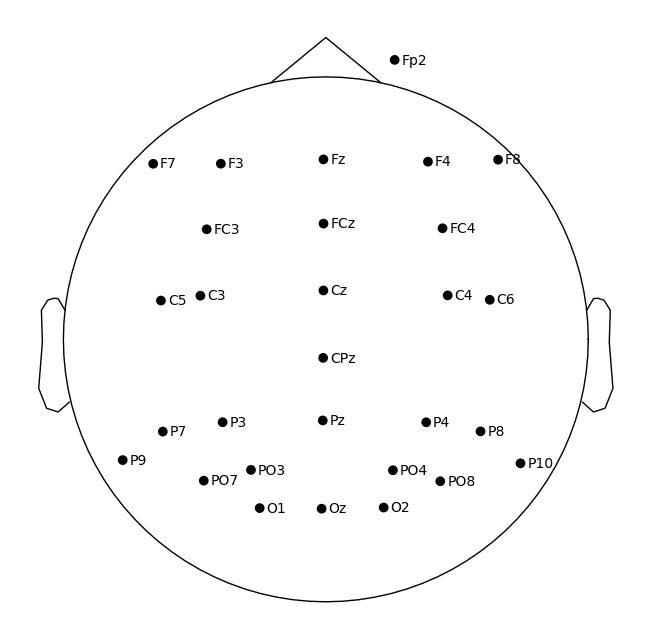

In [8]:
raw.plot_sensors(show_names=True);

# Plot power spectral density
This is the frequency-domain representation of the EEG data. It shows how much power is present in the EEG signal at each frequency. This can be useful for identifying artifacts in the data, as well as for understanding the frequency content of the signal.

/Users/aaron/miniforge3/envs/ncil/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


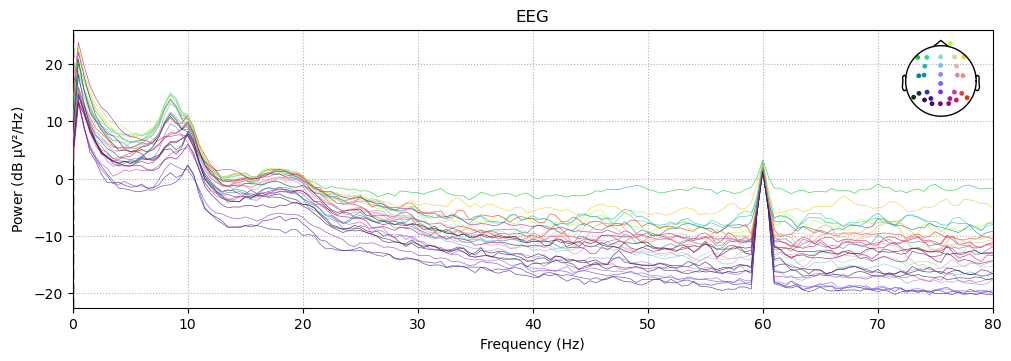

In [9]:
raw.compute_psd(fmax=80).plot()
plt.show()

# Bandpass filter the data and replot

In [10]:
raw.filter(0.1, 40)

<RawEEGLAB | sub-012_task-N400_eeg.fdt, 31 x 399360 (390.0 s), ~94.5 MB, data loaded>

/Users/aaron/miniforge3/envs/ncil/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


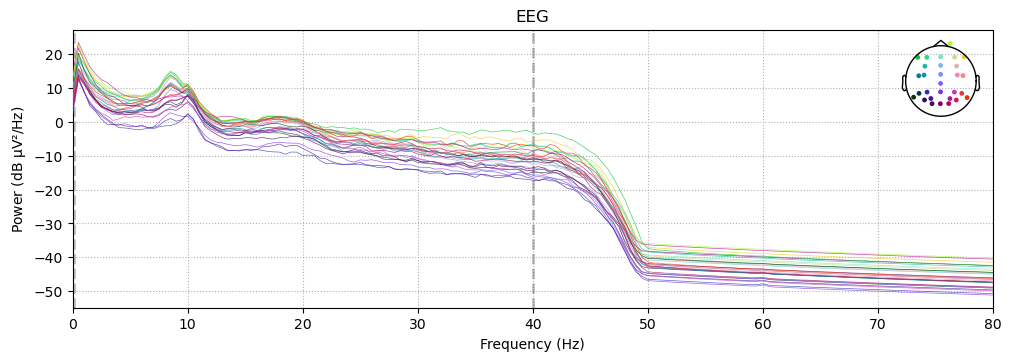

In [11]:
raw.compute_psd(fmax=80).plot()
plt.show()

# Event processing

Find event markers in data, and label them appropriately. This is a crucial step in EEG data analysis, because it allows us to segment the data into epochs, which are time-locked to the onset of a stimulus or response. This is the basis for all further analysis of EEG data.

In [12]:
events, event_id = mne.events_from_annotations(raw)

event_id_map = {'111': 'prime/related/list1',
                '112': 'prime/related/list2',
                '121': 'prime/unrelated/list1',
                '122': 'prime/unrelated/list2',
                '211': 'target/related/list1',
                '212': 'target/related/list2',
                '221': 'target/unrelated/list1',
                '222': 'target/unrelated/list2',
                '201': 'resp/correct/list1',
                '202': 'resp/incorrect/list2'
                }

# map values of event_id_map to keys of event_id and save as event_id_new
event_id_new = {event_id_map[key]: value for key, value in event_id.items()}

event_id_new


{'prime/related/list1': 1,
 'prime/related/list2': 2,
 'prime/unrelated/list1': 3,
 'prime/unrelated/list2': 4,
 'resp/correct/list1': 5,
 'resp/incorrect/list2': 6,
 'target/related/list1': 7,
 'target/related/list2': 8,
 'target/unrelated/list1': 9,
 'target/unrelated/list2': 10}

# Epoch the data

This is the process of cutting the continuous EEG data into segments, or epochs, that are time-locked to the onset of a stimulus or response. 

In [13]:
tmin = -0.100
tmax =  1.000
epochs_ica = mne.Epochs(raw.copy().filter(1, 30), 
                        events, event_id_new, 
                        tmin=tmin, tmax=tmax, 
                        baseline=(None, 0), 
                        preload=True)

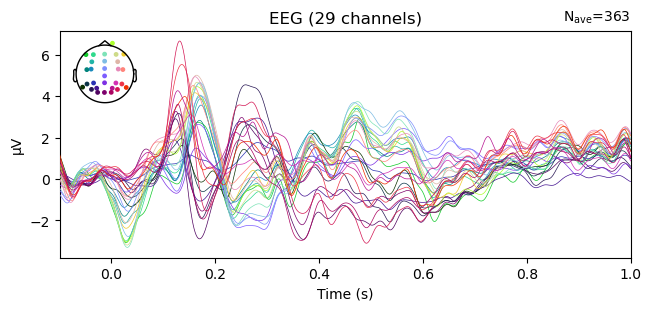

In [14]:
epochs_ica.average().plot()
plt.show()

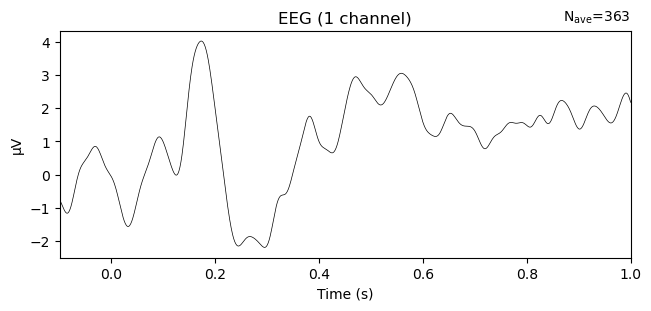

In [15]:
epochs_ica.average().plot(picks=['Cz'])
plt.show()

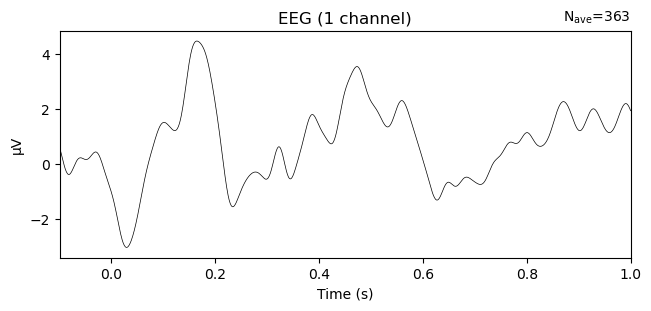

In [16]:
epochs_ica.average().plot(picks=['Fp2'])
plt.show()

# Run ICA

Independent Component Analysis (ICA) is a method for separating the EEG signal into independent components, each of which represents a different source of neural activity. This can be useful for removing artifacts from the data, such as eye blinks.

In [17]:
ica = mne.preprocessing.ICA(n_components=.975, 
                             random_state=42, 
                             max_iter='auto'
                             )
ica.fit(epochs_ica,
        decim=3, 
        picks=['eeg']
        )

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,82 iterations on epochs (136488 samples)
ICA components,15
Available PCA components,29
Channel types,eeg
ICA components marked for exclusion,—


## Identify and remove ocular ICA components

In [18]:
ica.exclude = []
num_excl = 0
z_thresh = 4
z_step = .25

while num_excl < 1 and z_thresh > 0:
    eog_indices, eog_scores = ica.find_bads_eog(epochs_ica, threshold=z_thresh)
    num_excl = len(eog_indices)
    z_thresh -= z_step # won't impact things if num_excl is ≥ n_max_eog 

ica.exclude = eog_indices
z_thresh_final = round(z_thresh + z_step, 2)
print(num_excl, 'components excluded with z_thresh =', z_thresh_final)

1 components excluded with z_thresh = 3.0


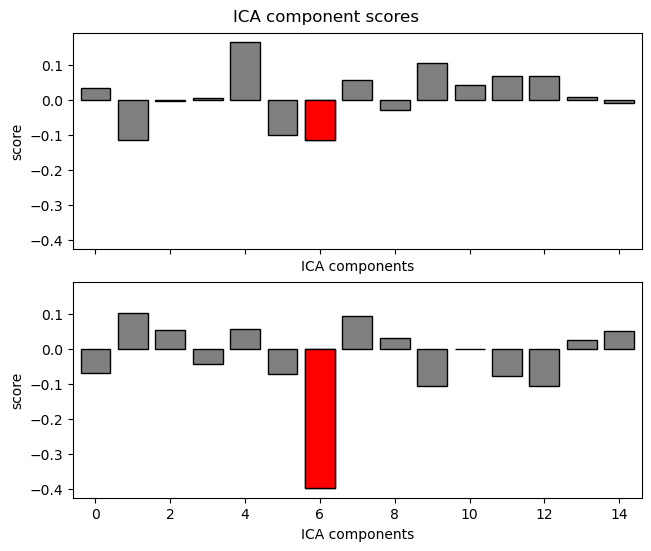

In [19]:
mne.viz.plot_eog_scores = ica.plot_scores(eog_scores)

## Plot the scalp distribution of each ICA component

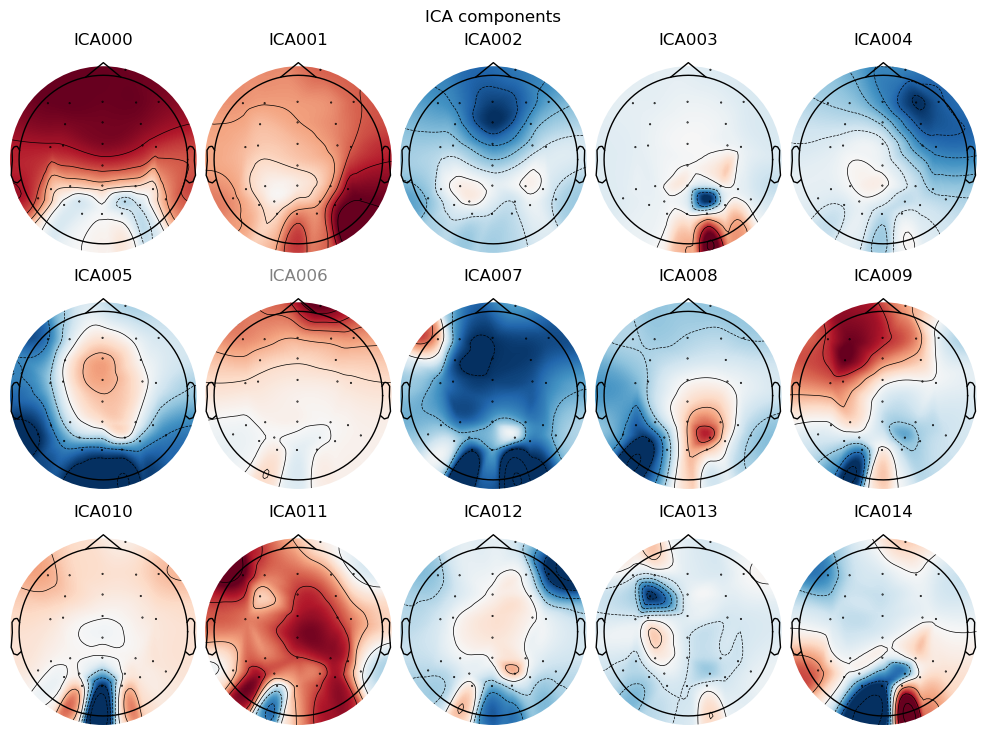

In [20]:
ica.plot_components()
plt.show()

# Create epochs for visualization and analysis

These are filtered differently from how it was done for ICA

In [21]:
epochs = mne.Epochs(raw,
                    events, event_id_new, 
                    tmin=tmin, tmax=tmax, 
                    baseline=(None, 0), 
                    preload=True)

ica.apply(epochs);


## Compare average of all epochs before and after ICA correction

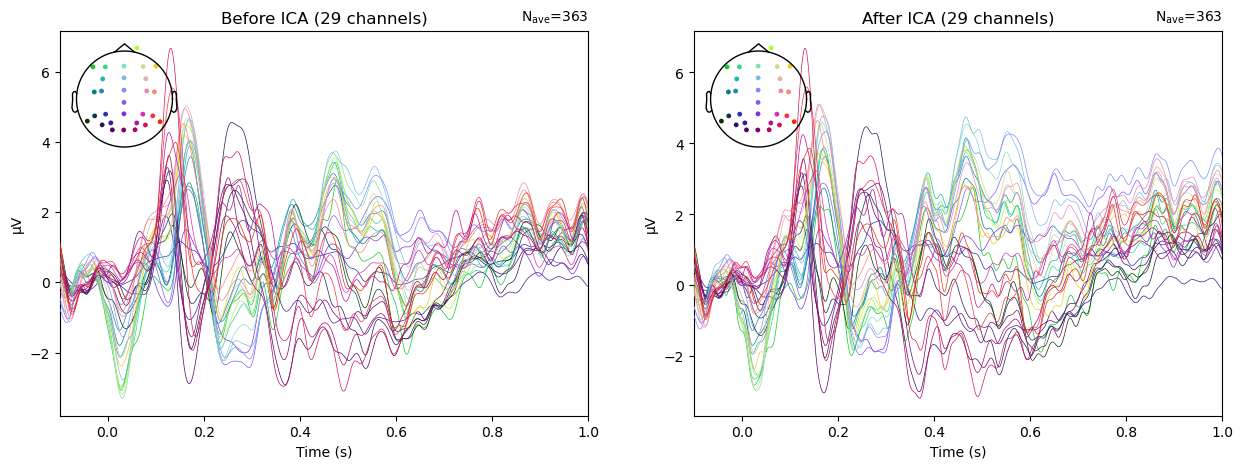

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
epochs_ica.average().plot(axes=axs[0], titles='Before ICA', show=False)
epochs.average().plot(axes=axs[1], titles='After ICA', show=True)
plt.show()

# Re-reference the data to averaged mastoids

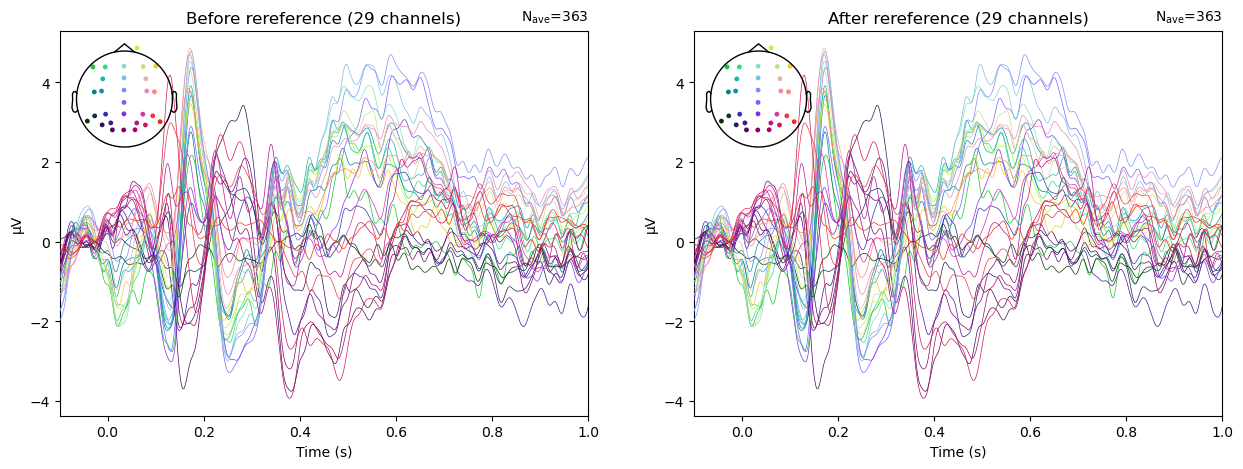

In [23]:
epochs_rr = epochs.set_eeg_reference(['P9', 'P10'])

derivatives_path = op.join('..', 'derivatives', subject)
if Path(derivatives_path).exists() == False:
    Path(derivatives_path).mkdir(parents=True)
epochs_rr.save(op.join(derivatives_path, subject + '-epo.fif'), overwrite=True)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
epochs.average().plot(axes=axs[0], titles='Before rereference', show=False)
epochs_rr.average().plot(axes=axs[1], titles='After rereference', show=True)
plt.show()

# Average across trials for each condition

In [24]:
cond_of_interest = ['prime/related', 'prime/unrelated', 'target/related', 'target/unrelated']
evoked = {}
for condition in cond_of_interest:
    evoked[condition] = epochs_rr[condition].average()

## Plot average ERPs

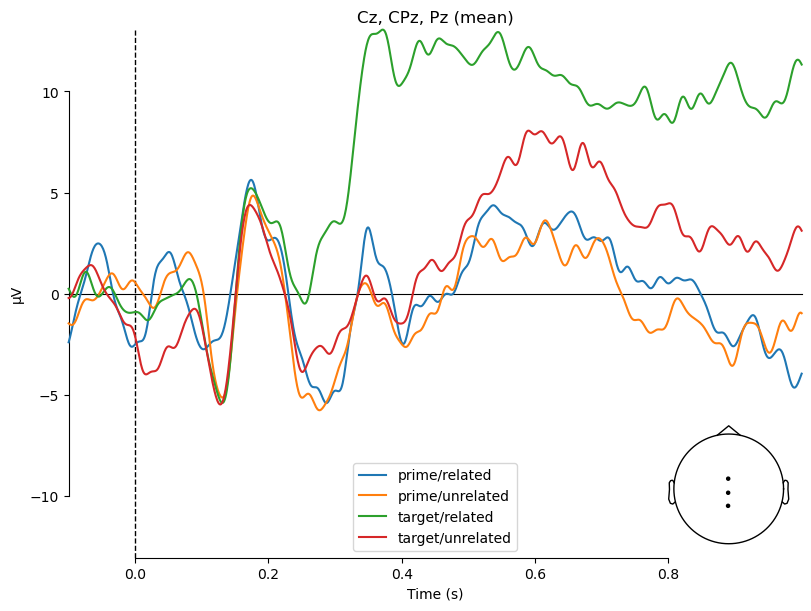

In [25]:
roi = ['Cz', 'CPz', 'Pz']
mne.viz.plot_compare_evokeds({c:evoked[c] for c in cond_of_interest},
                              picks=roi, combine='mean',
                              show_sensors='lower right', legend='lower center', 
                              ci=False,
                            );

# Compute difference waves between conditions

In [26]:
contrasts = {'related': ['prime/related', 'target/related'],
             'unrelated': ['prime/unrelated', 'target/unrelated'],
             'mismatch': ['target/unrelated', 'target/related']
             }

evoked_diff = {}
for contrast, conditions in contrasts.items():
  evoked_diff[contrast] = [mne.combine_evoked([evoked[conditions[0]], evoked[conditions[1]]],
                                              weights=[1, -1])

                            ]
  

## Plot difference waves

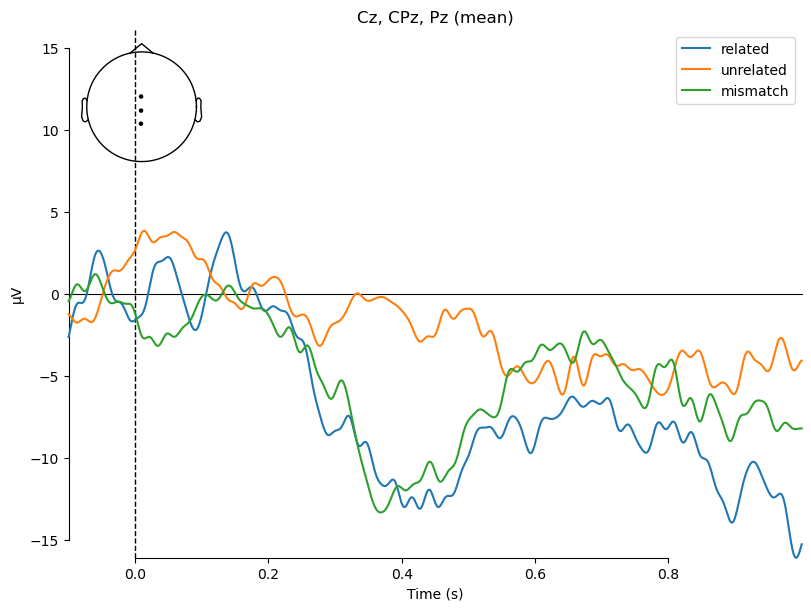

In [27]:
roi = ['Cz', 'CPz', 'Pz']
mne.viz.plot_compare_evokeds(evoked_diff, 
                             picks=roi, 
                             show_sensors='upper left', 
                             legend='upper right',
                             combine='mean',
                            #  ylim = {'eeg': (-3, 3)}
                             )
                             
plt.show()

# Plot scalp topographies of difference waves


 related


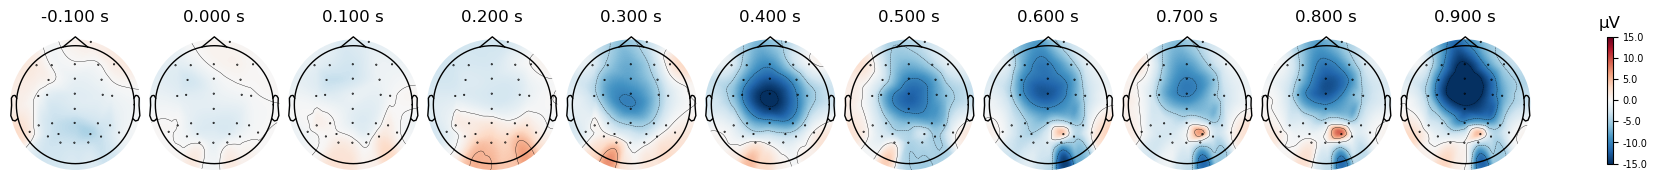


 unrelated


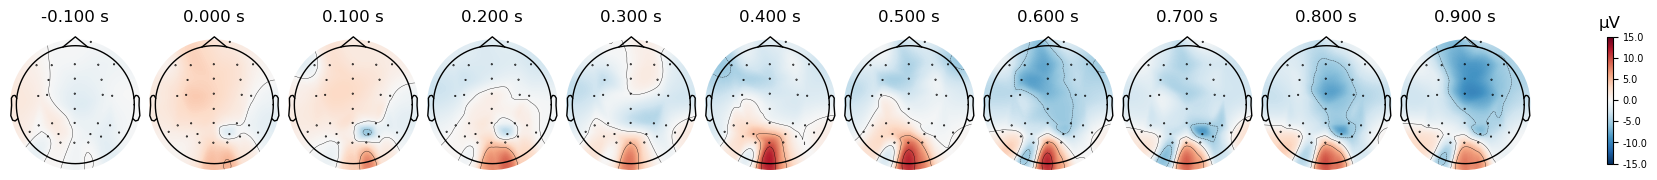


 mismatch


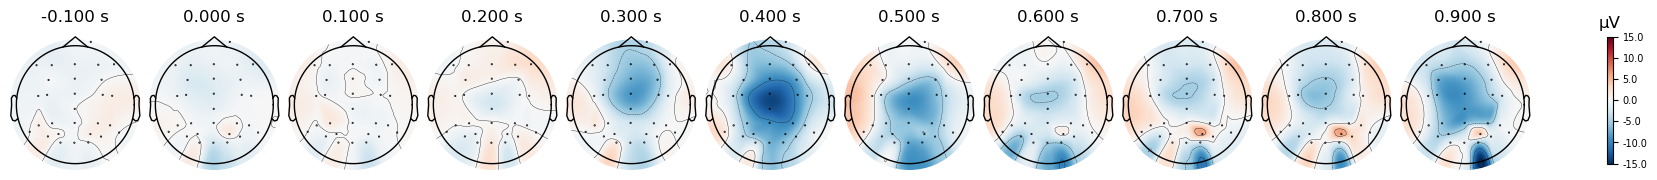

In [28]:
times = np.arange(tmin, tmax, .100)
uv_range = 15

for contrast in contrasts:
  print('\n', contrast)
  evoked_diff[contrast][0].plot_topomap(times, 
                                       ch_type='eeg', 
                                       vlim=[-uv_range, uv_range], 
                                       )